In [5]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.7/169.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.4-py3-none-any.whl size=200480 sha256=eec9dc6ae365c9c97d9617302eb3ceddae861903c061bd0d0f1598672713cb6e
  Stored in directory: /root/.cache/pip/wheels/cb/54/28/d02f62720600bc815c41219efedd0cb86889737fb5ea3c8f9a
Successfully built pyod


In [59]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from pyod.models.knn import KNN  # KLE Outlier Detection
import time

In [60]:
# Function to generate log file with a few injected outliers
def generate_log_file(file_path, num_entries=100, num_outliers=5):
    log_data = []
    ip_addresses = ["192.168.1.1", "192.168.1.2", "10.0.0.1", "10.0.0.2", "172.16.0.1"]

    # Generate normal entries
    for _ in range(num_entries):
        ip = random.choice(ip_addresses)
        failed_attempts = random.randint(0, 50)
        successful_attempts = random.randint(0, 10)
        timestamp = pd.Timestamp.now() - pd.Timedelta(seconds=random.randint(0, 3600))
        log_data.append([ip, failed_attempts, successful_attempts, timestamp])

    # Inject extreme outlier entries
    for _ in range(num_outliers):
        ip = random.choice(ip_addresses)
        # Extreme values to simulate intrusion
        failed_attempts = random.randint(60, 100)
        successful_attempts = random.randint(0, 1)
        timestamp = pd.Timestamp.now() - pd.Timedelta(seconds=random.randint(0, 3600))
        log_data.append([ip, failed_attempts, successful_attempts, timestamp])

    df = pd.DataFrame(log_data, columns=['ip_address', 'failed_attempts', 'successful_attempts', 'timestamps'])
    df.to_csv(file_path, index=False)
    print(f"Log file generated: {file_path}")

# Function to load dataset from log file
def load_dataset(csv_file):
    return pd.read_csv(csv_file)

In [61]:
# Function to detect intrusions using multiple models
def detect_intrusions_with_models(df):
    df['score'] = df['failed_attempts'] - df['successful_attempts']
    X = df[['score']]
    X_scaled = StandardScaler().fit_transform(X)

    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.2, random_state=42)
    df['iso_forest_outlier'] = iso_forest.fit_predict(X_scaled)
    # Map Isolation Forest outputs to binary (0: Normal, 1: Outlier)
    df['iso_forest_outlier'] = df['iso_forest_outlier'].map({1: 0, -1: 1})

    # DBSCAN
    # Adjusted eps and min_samples for 1D data
    dbscan = DBSCAN(eps=0.3, min_samples=3)
    df['dbscan_outlier'] = dbscan.fit_predict(X_scaled)
    df['dbscan_outlier'] = df['dbscan_outlier'].apply(lambda x: 1 if x == -1 else 0)
    df['dbscan_label'] = df['dbscan_outlier'].map({0: "Normal", 1: "Outlier"})

    # KNN (KLE Outlier)
    knn = KNN(contamination=0.2)
    knn.fit(X_scaled)
    df['kle_outlier'] = knn.predict(X_scaled)

    # Z-Score Outlier Detection
    df['z_score'] = np.abs((df['score'] - df['score'].mean()) / df['score'].std())
    df['z_score_outlier'] = (df['z_score'] > 2.5).astype(int)

    return df

In [62]:
# Function to plot intrusion detection results
def plot_iso(df):
    # Plot for Isolation Forest
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=df.index, y=df['score'],
                    hue=df['iso_forest_outlier'].astype(str),
                    palette={"0": "blue", "1": "red"})
    plt.xlabel("Log Entry")
    plt.ylabel("Intrusion Score")
    plt.title("Intrusion Detection using Isolation Forest")
    plt.legend(title="Outlier", labels=["Normal", "Intrusion"])
    plt.show()

def plot_dbscan(df):
    # Plot for DBSCAN using the label column
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=df.index, y=df['score'],
                    hue=df['dbscan_label'],
                    palette={"Normal": "blue", "Outlier": "red"})
    plt.xlabel("Log Entry")
    plt.ylabel("Intrusion Score")
    plt.title("Intrusion Detection using DBSCAN")
    plt.legend(title="DBSCAN Outlier", labels=["Normal", "Outlier"])
    plt.show()

def plot_zscore(df):
    # Plot for Z-Score Outlier Detection
    df['z_score_outlier_str'] = df['z_score_outlier'].astype(str)
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x="score", bins=20, kde=True, hue="z_score_outlier_str",
                 palette={"0": "blue", "1": "red"})
    plt.xlabel("Intrusion Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Scores with Z-Score Outliers")
    plt.show()

In [63]:
# Generate log file with extra outlier entries
log_file_path = "intrusion_logs.csv"
generate_log_file(log_file_path, num_entries=100, num_outliers=5)

# Load dataset
logs_df = load_dataset(log_file_path)

# Detect intrusions
intrusions = detect_intrusions_with_models(logs_df)

# Display results
print("Intrusion Detection Results:")
print(intrusions)

Log file generated: intrusion_logs.csv
Intrusion Detection Results:
      ip_address  failed_attempts  successful_attempts  \
0    192.168.1.1               23                    9   
1       10.0.0.2                9                    2   
2    192.168.1.2               27                    8   
3     172.16.0.1               21                    3   
4    192.168.1.2               39                    3   
..           ...              ...                  ...   
100     10.0.0.1               64                    1   
101     10.0.0.2               70                    1   
102     10.0.0.2               87                    1   
103  192.168.1.1               73                    1   
104   172.16.0.1               97                    0   

                     timestamps  score  iso_forest_outlier  dbscan_outlier  \
0    2025-03-26 15:41:10.844211     14                   0               0   
1    2025-03-26 15:21:44.844322      7                   0               0   
2

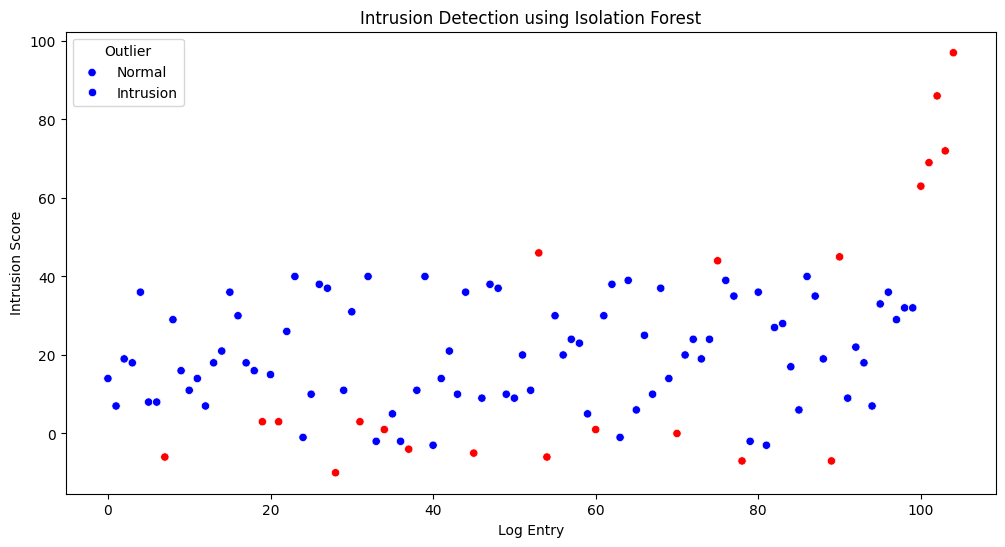

In [64]:
# Plot results
plot_iso(intrusions)

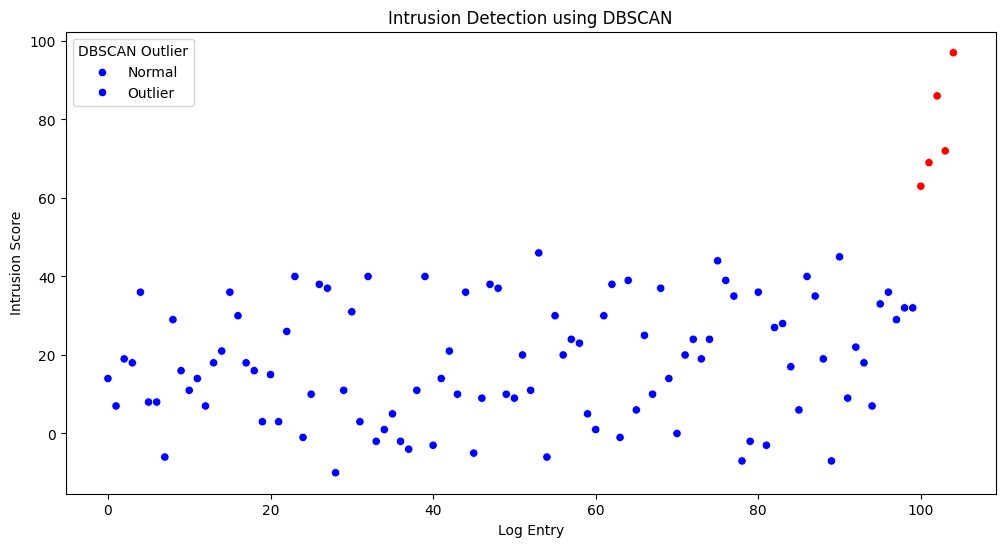

In [65]:
plot_dbscan(intrusions)

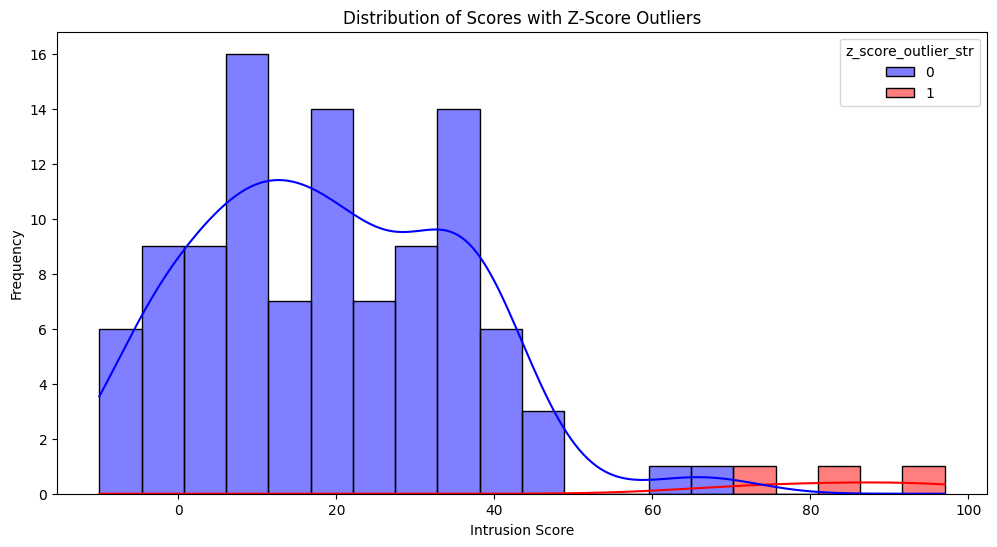

In [66]:
plot_zscore(intrusions)

In [ ]:
#end_of_File